0       3.910000e-03
1       7.810000e-03
2       1.170000e-02
3       1.950000e-02
4       2.730000e-02
5       3.520000e-02
6       4.300000e-02
7       5.860000e-02
8       7.420000e-02
9       1.054688e-01
10      1.367188e-01
11      1.992188e-01
12      2.617188e-01
13      3.867188e-01
14      5.117188e-01
15      6.367188e-01
16      8.867188e-01
17      1.386719e+00
18      2.386719e+00
19      3.386719e+00
20      4.386719e+00
21      6.386719e+00
22      8.386719e+00
23      1.038672e+01
24      1.438672e+01
25      1.838672e+01
26      2.238672e+01
27      2.638672e+01
28      3.038672e+01
29      3.838672e+01
            ...     
3960    9.540000e+09
3961    9.560000e+09
3962    9.560000e+09
3963    9.570000e+09
3964    9.590000e+09
3965    9.600000e+09
3966    9.620000e+09
3967    9.640000e+09
3968    9.650000e+09
3969    9.670000e+09
3970    9.690000e+09
3971    9.700000e+09
3972    9.720000e+09
3973    9.740000e+09
3974    9.750000e+09
3975    9.770000e+09
3976    9.790

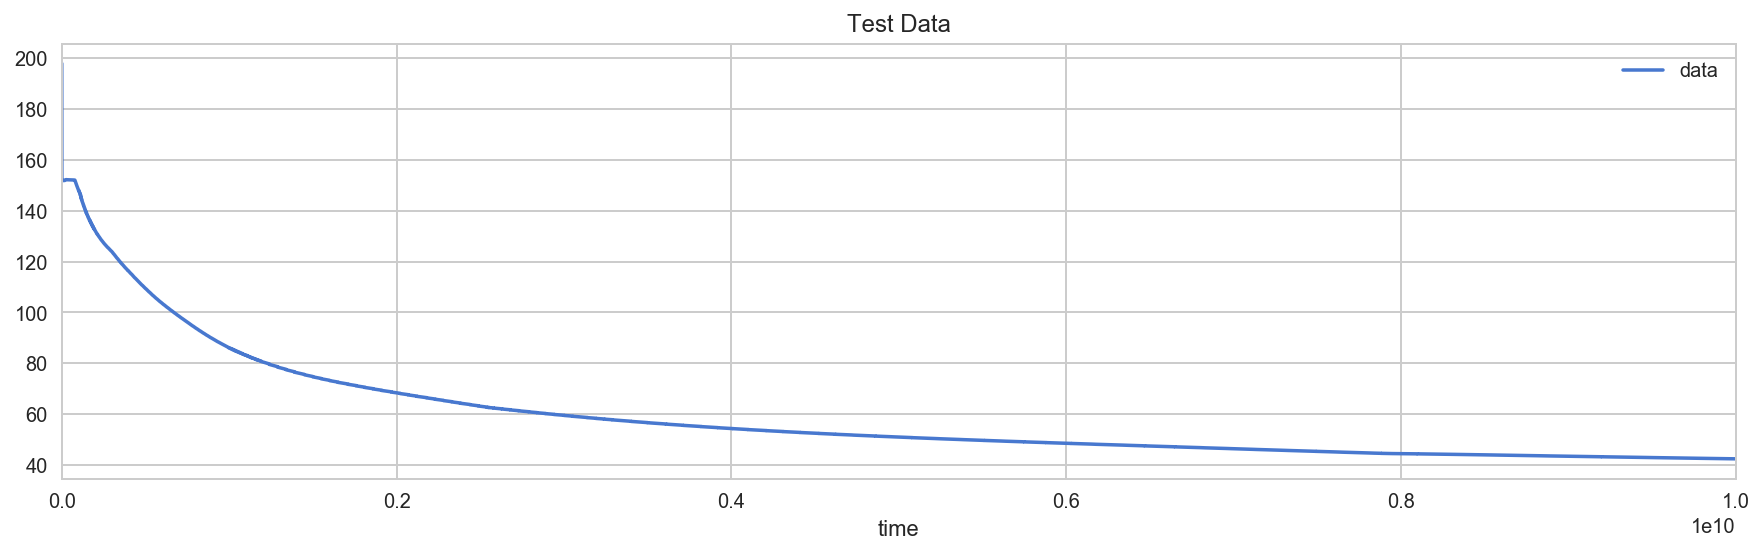

In [56]:
import numpy as np
import numpy.random as rd
import pandas as pd

import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid", palette="muted", color_codes=True)
%matplotlib inline
%config InlineBackend.figure_format='retina'
df = pd.read_csv("temp.csv", header=-1)
print(df[0])
df.columns = ('time', 'data') 
print(df)
df.plot(x='time',y='data',figsize=(15,4))
plt.title("Test Data")



In [51]:
class ParticleFilter(object):
    def __init__(self, y, n_particle, sigma_2, alpha_2):
        self.y = y
        self.n_particle = n_particle
        self.sigma_2 = sigma_2
        self.alpha_2 = alpha_2
        self.log_likelihood = -np.inf
    
    def norm_likelihood(self, y, x, s2):
        return (np.sqrt(2*np.pi*s2))**(-1) * np.exp(-(y-x)**2/(2*s2))

    def F_inv(self, w_cumsum, idx, u):
            if np.any(w_cumsum < u) == False:
                return 0
            k = np.max(idx[w_cumsum < u])
            return k+1
        
    def resampling(self, weights):
        w_cumsum = np.cumsum(weights)
        idx = np.asanyarray(range(self.n_particle))
        k_list = np.zeros(self.n_particle, dtype=np.int32) # サンプリングしたkのリスト格納場所
        
        # 一様分布から重みに応じてリサンプリングする添え字を取得
        for i, u in enumerate(rd.uniform(0, 1, size=self.n_particle)):
            k = self.F_inv(w_cumsum, idx, u)
            k_list[i] = k
        return k_list

    def resampling2(self, weights):
        """
        計算量の少ない層化サンプリング
        """
        idx = np.asanyarray(range(self.n_particle))
        u0 = rd.uniform(0, 1/self.n_particle)
        u = [1/self.n_particle*i + u0 for i in range(self.n_particle)]
        w_cumsum = np.cumsum(weights)
        k = np.asanyarray([self.F_inv(w_cumsum, idx, val) for val in u])
        return k
    
    def simulate(self, seed=71):
        rd.seed(seed)

        # 時系列データ数
        T = len(self.y)
        
        # 潜在変数
        x = np.zeros((T+1, self.n_particle))
        x_resampled = np.zeros((T+1, self.n_particle))
        
        # 潜在変数の初期値
        initial_x = rd.normal(0, 1, size=self.n_particle)
        x_resampled[0] = initial_x
        x[0] = initial_x

        # 重み
        w        = np.zeros((T, self.n_particle))
        w_normed = np.zeros((T, self.n_particle))

        l = np.zeros(T) # 時刻毎の尤度

        for t in range(T):
            print("\r calculating... t={}".format(t), end="")
            for i in range(self.n_particle):
                # 1階差分トレンドを適用
                v = rd.normal(0, np.sqrt(self.alpha_2*self.sigma_2)) # System Noise
                x[t+1, i] = x_resampled[t, i] + v # システムノイズの付加
                w[t, i] = self.norm_likelihood(self.y[t], x[t+1, i], self.sigma_2) # y[t]に対する各粒子の尤度
            w_normed[t] = w[t]/np.sum(w[t]) # 規格化
            l[t] = np.log(np.sum(w[t])) # 各時刻対数尤度

            # Resampling
            #k = self.resampling(w_normed[t]) # リサンプルで取得した粒子の添字
            k = self.resampling2(w_normed[t]) # リサンプルで取得した粒子の添字（層化サンプリング）
            x_resampled[t+1] = x[t+1, k]
            
        # 全体の対数尤度
        self.log_likelihood = np.sum(l) - T*np.log(n_particle)
        
        self.x = x
        self.x_resampled = x_resampled
        self.w = w
        self.w_normed = w_normed
        self.l = l
        
    def get_filtered_value(self):
        """
        尤度の重みで加重平均した値でフィルタリングされ値を算出
        """
        return np.diag(np.dot(self.w_normed, self.x[1:].T))
        
    def draw_graph(self):
        # グラフ描画
        T = len(self.y)
        
        plt.figure(figsize=(16,8))
        plt.plot(range(T), self.y)
        plt.plot(self.get_filtered_value(), "g")
        
        for t in range(T):
            plt.scatter(np.ones(self.n_particle)*t, self.x[t], color="r", s=2, alpha=0.1)
        
        plt.title("sigma^2={0}, alpha^2={1}, log likelihood={2:.3f}".format(self.sigma_2, 
                                                                                 self.alpha_2, 
                                                                                 self.log_likelihood))
        #plt.show()

In [52]:
# ハイパーパラメーター
a = -2
b = -1

n_particle = 10**3 * 5
sigma_2 = 2**a
alpha_2 = 10**b

In [53]:
pf = ParticleFilter(df.data.values, n_particle, sigma_2, alpha_2)

In [54]:
pf.simulate()

 calculating... t=2

/Users/annasuzuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide
/Users/annasuzuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in log
/Users/annasuzuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]


 calculating... t=3989

In [ ]:
pf.draw_graph()